In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
# val_folder = 'val'
S_PREFIX = '41-resnet50'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    if pad_right == 32: pad_right = 0
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.875)
    yc[cutoff_y:,:] = 0
    rn = ~(yr | yc)
    return torch.from_numpy(np.stack((rn,yc,yr)).astype(int))

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [17]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None, val_bs=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    if val_bs is None: val_bs = bs
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    x_np = x_np*std+mean
    return x_np

### Visualize data

In [20]:
sz = 64
bs = 2
ext = '-150'
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [21]:
x,y = md.val_ds[259]

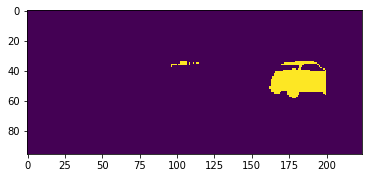

In [22]:
plt.imshow(y[1])

In [23]:
x_out = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


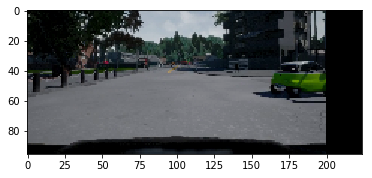

In [24]:
plt.imshow(x_out)

In [25]:
x,y = md.trn_ds[259]

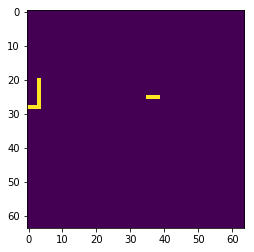

In [26]:
plt.imshow(y[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


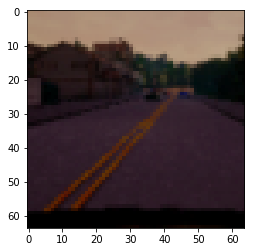

In [27]:
x_out = denorm(x)
plt.imshow(x_out)

## U-net (ish)

In [20]:
from torchvision.models import vgg11_bn

In [21]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [22]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [23]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [25]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [26]:
class Unet50(nn.Module):
    def __init__(self, f=resnet50):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(2048,1024,1024)
        self.up2 = UnetBlock(1024,512,512)
        self.up3 = UnetBlock(512,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,32,32)
        self.up6 = nn.ConvTranspose2d(32, 3, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(3,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
#         x = F.relu(self.rn(x), inplace=False)
        x = self.rn(x)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [27]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [28]:
def car_f_p_r(pred, targs):
#     p2 = F.sigmoid(pred)
    _,idx = torch.max(pred, 1)
    p2 = idx
    return fbeta_score(p2==1, targs[:,1,:,:], beta=2)

In [29]:
def rd_f(pred, targs):
    _,idx = torch.max(pred, 1)
#     p2 = F.sigmoid(pred)
    p2 = idx
    f,p,r = fbeta_score(p2==2, targs[:,2,:,:], beta=0.5)
    return f

In [30]:
def fbeta_score(y_pred, y_true, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [31]:
def new_acc(pred, targs):
    _,idx = torch.max(pred, 1)
    _,t_idx = torch.max(targs,1)
#     idx = F.softmax(pred) > 0.5
    return (idx == t_idx).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [32]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.softmax(logits)
        num = targets.size(0)  # Number of batches
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [33]:
def get_learner(md, m_fn=Unet50, half=False):
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([1,500,1])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

### Settings

In [44]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [45]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# learn.half()

In [46]:
learn.freeze_to(1)

In [47]:
# %pdb on

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.997096   0.99971    0.019154   0.016588   0.076097   0.016219   0.995944  



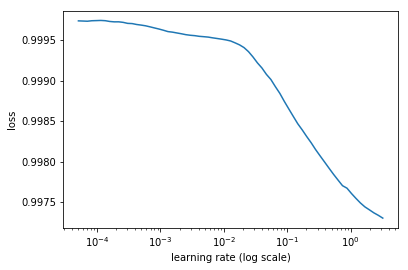

In [48]:
learn.lr_find()
learn.sched.plot()

In [56]:
lr=1e-2
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])

In [50]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.999177   0.998831   0.419281   0.350059   0.601464   0.341167   0.75536   
    1      0.996463   0.993948   0.447467   0.384754   0.634743   0.669892   0.630227  
    2      0.994677   0.993648   0.769834   0.620115   0.65968    0.531236   0.704734  
    3      0.994182   0.993548   0.834826   0.740703   0.525021   0.839328   0.481221  
    4      0.994      0.993325   0.900438   0.886243   0.536238   0.78818    0.499027  
    5      0.993841   0.993808   0.901322   0.840888   0.48099    0.850649   0.43622   
    6      0.993742   0.994442   0.918256   0.89748    0.375938   0.869378   0.330623  
    7      0.993771   0.993734   0.929181   0.901232   0.462587   0.812071   0.418695  
    8      0.993739   0.993258   0.932685   0.912167   0.553214   0.789741   0.515728  
    9      0.993751   0.993258   0.867294   0.86632    0.649551   0.639945   0.654088  
    10     0.993752   0.993676   0.905338   0.913993 

[array([0.99221]),
 0.9613655519485473,
 0.9520121335088875,
 0.7139237533419647,
 0.8216872573428705,
 0.692882320890905]

In [51]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [54]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [55]:
learn.unfreeze()
learn.bn_freeze(True)

In [57]:
learn.fit(lrs/10,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993337   0.992158   0.961901   0.945166   0.721113   0.818228   0.701891  
    1      0.993315   0.992156   0.961686   0.952754   0.721406   0.818024   0.702236  
    2      0.993307   0.99219    0.961946   0.951444   0.705951   0.842214   0.680212  
    3      0.993308   0.992158   0.960988   0.949495   0.720716   0.824704   0.700197  
    4      0.993291   0.99208    0.962885   0.952725   0.732003   0.814278   0.715299  
    5      0.993294   0.992083   0.960207   0.955883   0.72742    0.822048   0.708472  
    6      0.993275   0.992119   0.963632   0.951299   0.716559   0.836262   0.693213  
    7      0.99326    0.992152   0.962846   0.952346   0.711232   0.838656   0.686647  
    8      0.993245   0.992114   0.961123   0.958515   0.719799   0.833942   0.69745   
    9      0.993256   0.992067   0.96328    0.954962   0.738501   0.810992   0.723969  
    10     0.993241   0.992138   0.963401   0.948319 

[array([0.99196]),
 0.9680183863639832,
 0.9624424877825843,
 0.7399273528719141,
 0.8482785108076776,
 0.71815693926854]

In [58]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0.5);

In [ ]:
show_img(py[0][1]>0.5);

In [ ]:
show_img(y[0][1]);

## 256x256

In [20]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [21]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])

In [22]:
import gc
gc.collect()

0

In [38]:
learn = get_learner(md)

In [63]:
learn.load(f'128urn-{S_PREFIX}-0')

In [64]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [65]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.988818   0.986526   0.85444    0.789159   0.801281   0.758317   0.814109  
    1      0.986704   0.986048   0.934431   0.924411   0.738203   0.868252   0.713431  
    2      0.986504   0.985926   0.947833   0.941991   0.766754   0.824784   0.754801  
    3      0.986502   0.986042   0.949263   0.94658    0.733554   0.877414   0.706276  
    4      0.986382   0.985979   0.942704   0.943798   0.790529   0.764653   0.799656  
    5      0.986326   0.986053   0.930981   0.937838   0.717793   0.896388   0.685207  
    6      0.986352   0.985814   0.938448   0.945435   0.747903   0.873752   0.723251  
    7      0.986394   0.989282   0.929376   0.896476   0.435907   0.943899   0.386446  
    8      0.986284   0.985825   0.938386   0.905111   0.818687   0.791483   0.826665  
    9      0.986449   0.987151   0.849807   0.747651   0.798692   0.63073    0.861107  
    10     0.986496   0.986132   0.931749   0.934031 

[array([0.98503]),
 0.9674292039871216,
 0.9620915833383313,
 0.8108375843444117,
 0.8872430495052691,
 0.794694830902983]

In [66]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [39]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [40]:
learn.unfreeze()
learn.bn_freeze(True)

In [41]:
learn.fit(lrs/20,1,wds=wd,cycle_len=15,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985761   0.984993   0.967688   0.961783   0.81537    0.885702   0.80029   
    1      0.985786   0.984985   0.967528   0.962251   0.814783   0.890373   0.79855   
    2      0.985779   0.985032   0.967649   0.961389   0.808491   0.891811   0.790905  
    3      0.985767   0.985004   0.968545   0.962662   0.813387   0.887156   0.797708  
    4      0.985784   0.984965   0.968222   0.963835   0.81731    0.884642   0.802804  
    5      0.985729   0.985029   0.968284   0.959562   0.806734   0.894232   0.788271  
    6      0.985749   0.985      0.968651   0.958277   0.815575   0.882479   0.801186  
    7      0.985764   0.984955   0.968323   0.959179   0.822544   0.876733   0.810764  
    8      0.985776   0.984945   0.968781   0.960255   0.818574   0.886476   0.803913  
    9      0.98573    0.984898   0.969309   0.963569   0.826034   0.882167   0.813757  
    10     0.985702   0.984988   0.969085   0.964543 

[0.9849471139907837,
 0.9694376277923584,
 0.9631004500389099,
 0.8190936851501465,
 0.8857684206962585,
 0.8047131276130677]

In [42]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:8])))

In [ ]:
plt.imshow(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

### No Crop

In [43]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [44]:
learn = get_learner(md)

In [49]:
learn.load(f'256urn-{S_PREFIX}')

In [50]:
learn.unfreeze()
learn.bn_freeze(True)

In [52]:
lr=1e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])

In [53]:
learn.fit(lrs,1,wds=wd,cycle_len=15,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.970989   0.972027   0.97035    0.962807   0.820777   0.880042   0.808515  
    1      0.970937   0.972012   0.968483   0.966283   0.822764   0.878889   0.811112  
    2      0.970886   0.971964   0.96921    0.963781   0.831336   0.866694   0.824019  
    3      0.970874   0.971901   0.971229   0.964184   0.834022   0.868348   0.827046  
    4      0.970865   0.971811   0.972841   0.965322   0.836959   0.871368   0.830101  
    5      0.970812   0.971809   0.973139   0.966578   0.832037   0.879944   0.822234  
    6      0.970819   0.971801   0.972655   0.969855   0.837644   0.870569   0.831046  
    7      0.970704   0.971776   0.974256   0.971333   0.825775   0.894806   0.811361  
    8      0.97065    0.971683   0.974508   0.965748   0.844807   0.868232   0.840427  
    9      0.97069    0.971645   0.973614   0.96318    0.841938   0.877682   0.834669  
    10     0.97064    0.971637   0.97547    0.967069 

[0.9715927815437317,
 0.9758083558082581,
 0.9702679181098938,
 0.8365295767784119,
 0.8923980617523193,
 0.8248643708229065]

In [55]:
learn.fit(lr/4,1,wds=wd, cycle_len=6,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.970898   0.972101   0.9665     0.971727   0.822641   0.86663    0.81448   
    1      0.971738   0.973718   0.962325   0.952743   0.758653   0.826734   0.746056  
    2      0.970745   0.97155    0.976515   0.974142   0.846932   0.879869   0.840557  
    3      0.970683   0.971692   0.975382   0.976276   0.833019   0.891917   0.821385  
    4      0.970616   0.971462   0.977947   0.976096   0.838175   0.903888   0.824499  
    5      0.970464   0.971326   0.978064   0.979186   0.854026   0.889174   0.8469    


[0.9713256692886353,
 0.9780641198158264,
 0.979186294078827,
 0.8540263557434082,
 0.889173800945282,
 0.8468999910354614]

In [56]:
learn.save(f'256urn-{S_PREFIX}-nocrop')

## 512x512

In [34]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [ ]:
learn.lr_find()
learn.sched.plot()

In [39]:
# learn.load(f'256urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [40]:
learn.freeze_to(1)

In [39]:
lr=1e-3
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])

In [42]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [43]:
learn.fit(lrs,1,wds=wd,cycle_len=8,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.944353   0.947733   0.899996   0.870961   0.789146   0.884932   0.770895  
    1      0.943666   0.947284   0.913104   0.889856   0.796806   0.886973   0.779718  
    2      0.943466   0.947019   0.918528   0.884098   0.813317   0.86859    0.803165  
    3      0.942742   0.946942   0.922238   0.893533   0.797052   0.900979   0.777222  
    4      0.942569   0.947075   0.926212   0.895391   0.791462   0.903199   0.770098  
    5      0.942492   0.947117   0.926585   0.900786   0.788996   0.905467   0.766979  
    6      0.942337   0.946616   0.929213   0.898949   0.808737   0.891296   0.792846  
    7      0.942245   0.946674   0.928733   0.901538   0.804845   0.896143   0.787307  



[0.946674199104309,
 0.9287327289581299,
 0.9015383625030517,
 0.8048445415496827,
 0.8961431956291199,
 0.7873068237304688]

In [ ]:
# learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [ ]:
# learn.fit(lr/4,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [44]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [35]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=320
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder, val_bs=16)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [36]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [37]:
learn.unfreeze()
learn.bn_freeze(True)

In [40]:
learn.fit(lr/6,1, wds=wd, cycle_len=6,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.971553   0.948466   0.908052   0.833127   0.762177   0.901411   0.73668   
    1      0.97133    0.948571   0.931515   0.876833   0.745638   0.919339   0.716596  
    2      0.971298   0.947863   0.938446   0.912308   0.76671    0.90731    0.741302  
    3      0.971062   0.946243   0.937829   0.916655   0.838364   0.852501   0.838476  
    4      0.970846   0.945994   0.949844   0.921926   0.811514   0.910611   0.792637  
    5      0.970846   0.945829   0.94596    0.921185   0.819172   0.90482    0.802699  



[0.9458291721343994,
 0.9459600806236267,
 0.9211847400665283,
 0.8191722059249877,
 0.9048199439048767,
 0.8026993501186371]

In [41]:
learn.save(f'600urn-{S_PREFIX}-tmp-2')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [42]:
learn.unfreeze()
learn.bn_freeze(True)

In [43]:
lrs = np.array([lr/200,lr/20,lr])/2

In [44]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.970786   0.945822   0.946506   0.924291   0.818685   0.905982   0.801875  
    1      0.970849   0.945789   0.947233   0.92407    0.819858   0.905271   0.803424  
    2      0.970815   0.945805   0.947342   0.923527   0.818531   0.906876   0.801524  
    3      0.970817   0.945809   0.94738    0.924166   0.818182   0.907279   0.801022  



[0.9458085918426513,
 0.9473800468444824,
 0.9241660928726196,
 0.818181824684143,
 0.9072794246673584,
 0.8010216057300568]

In [ ]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [45]:
learn.save(f'600urn-{S_PREFIX}')

In [46]:
f'600urn-{S_PREFIX}'

'600urn-41-resnet50'

In [ ]:
learn.sched.plot_loss()

### No Crop

In [47]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:10880, y:10880
All x:10880


In [48]:
import gc
gc.collect()

279

In [49]:
learn.load(f'600urn-{S_PREFIX}')
# learn.load(f'256urn-{S_PREFIX}-nocrop')
# learn.load('600urn-19-weights-26-r8')

In [50]:
lr=5e-4
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [51]:
learn.unfreeze()
learn.bn_freeze(True)

In [52]:
learn.fit(lrs,1, wds=wd,cycle_len=4,use_clr=(20,2))

  0%|          | 0/680 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generic/THCStorage.cu:58

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-nocrop-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp-2')

In [ ]:
learn.fit(lrs/100,1, wds=wd,cycle_len=4,use_clr=(20,2))

In [ ]:
learn.fit(lrs/50,1, wds=wd,cycle_len=4,use_clr_beta=(20,20,0.95,0.85))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [ ]:
learn.load(f'600urn-36-resnet-softmax-nocrop-tmp')

In [ ]:
val_it = iter(md.val_dl)

In [ ]:
x,y = next(val_it)

In [ ]:
x[1].mean()

In [ ]:
x.shape

In [ ]:
type(x)

In [ ]:
res = learn.model(V(x).cuda())

In [ ]:
mx,idx = torch.max(res,1)
idx = idx.cpu().data.numpy()

In [ ]:
idx.shape

In [ ]:
type(idx)

In [ ]:
i=0

In [ ]:
plt.imshow(denorm(x[i]))

In [ ]:
show_img(idx[i]);

In [ ]:
idx[0].mean()

In [ ]:
show_img(py[idx][1]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[idx][0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m = Unet34()

In [ ]:
cuda_enabled = torch.cuda.is_available()
DATA_PATH = Path('../data/all')
model_path = str(DATA_PATH/'models/600urn-36-resnet-softmax-nocrop-tmp.h5')
# model_path = str(PATH/'models/600urn-19-weights-26-r9.h5')
if cuda_enabled:
    m = m.cuda()
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
else:
    m.load_state_dict(torch.load(model_path))


In [ ]:

# file = sys.argv[-1]

R_PATH = Path.cwd()
file = R_PATH/'test_video.mp4'
mismatched_idxs = []
student_output = R_PATH/'tester_data_crop'
ans_key = R_PATH/'results.json'

# R_PATH = Path('../data/lyft-answers')
# file = R_PATH/'test_video.mp4'
# ans_key = R_PATH/'results.json'
# mismatched_idxs = list(range(15,44)) + list(range(200,750))
# student_output = R_PATH/'tester_data_crop'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)


In [ ]:
imagenet_stats = torch.cuda.FloatTensor([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    if x.mean() > 1:
        x.div_(255.0)
    m,s = imagenet_stats
#     return TVF.normalize(x, m, s)
#     print(x.shape)
    x.sub_(m.view(-1, 1, 1))
    x.div_(s.view(-1, 1, 1))
    return x

def crop_bg(x):
    # Original
    h = x.shape[2]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    return x[:,:,top:bot,:]

def pad(x):
#     print(x.shape)
    # Original
    b,c,w,h = x.shape
#     print(x.shape)
    if h%32 == 0:
        return x, 0
    pad_right=32-h%32
    if pad_right:
        x = F.pad(x, (0,pad_right,0,0), 'constant', 0)
    return x, pad_right
    
def undo(idx):
    idx
    idx = F.pad(idx, (0,0,226,54), "constant", 0)

def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = np.rollaxis(video, 3, 1)
    f1 = torch.from_numpy(f1).float().cuda()
    f1 = crop_bg(f1)
    f1 = normalize(f1)
    return f1.contiguous()

In [ ]:
video_p = preprocess(video)
if len(video_p) == 31:
    video_p = torch.cat((video_p[:15], video_p[16:]))

In [ ]:
import gc
gc.collect()

In [ ]:
results = []
raw_results = []
raw_frames = []
answer_key = {}
bs = 4

        
for i in range(0,video_p.shape[0],bs):
    x = video_p[i:i+bs]
    
#     x = torch.from_numpy(f1).contiguous().float()
#     if cuda_enabled:
#         x = x.cuda()
        
    x,p = pad(x)
    preds = m(torch.autograd.Variable(x))
#     preds = F.sigmoid(preds)
    # Indexes
    mx,idx = torch.max(preds, 1)
    for i in idx:
        raw_frames.append(i.data.cpu().numpy())
    if p > 0:
        idx = idx[:,:,:-p]
    idx = F.pad(idx, (0,0,160,56), "constant", 0)
    frame_idx = 1+i
    for frame in idx:
        frame = frame.data.cpu().numpy()
#         results.append(frame)
        raw_frames.append(frame)
        binary_car_result = (frame==1).astype('uint8')
        binary_road_result = (frame==2).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
        raw_results.append([binary_car_result, binary_road_result])
        results.append([encode(binary_car_result), encode(binary_road_result)])
        frame_idx+=1
    
    # Preds
#     if p > 0:
#         preds = preds[:,:,:,:-p]
#     preds = F.pad(preds, (0,0,160,56,0,0), "constant", 0)
#     frame_idx = 1+i
#     for frame in preds:
#         frame = frame.data.cpu().float().numpy()
#         f_results.append(frame)
#         binary_car_result = (frame[0]>0.5).astype('uint8')
#         binary_road_result = (frame[1]>0.5).astype('uint8')
#         answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
#         raw_results.append([binary_car_result, binary_road_result])
#         results.append([encode(binary_car_result), encode(binary_road_result)])
#         frame_idx+=1

In [ ]:
type(video_p.cpu())

In [ ]:
type(x)

In [ ]:
video_p[0,:,50:200,700:].sum(), x[0,:,50:200,700:].cuda().sum()

In [ ]:
video_p[0].shape

In [ ]:
x[0].shape

In [ ]:
x[0][2][200].cuda().sum()

In [ ]:
(video_p[0] - x[0].cuda()).sum()

In [ ]:
md.val_ds.fnames

In [ ]:
show_idx = 0

In [ ]:
video_p[show_idx].mean(), x[show_idx].mean()

In [ ]:
plt.imshow(denorm(x[0]))

In [ ]:
plt.imshow(denorm(video_p[show_idx]))

In [ ]:
learn_res = learn.model(V(video_p[0:4]))

In [ ]:
_,learn_idx = torch.max(learn_res,1)
learn_idx = learn_idx.cpu().data.numpy()

In [ ]:
plt.imshow(learn_idx[show_idx])

In [ ]:
learn_dl_res = learn.model(V(x[0:4].cuda()))

In [ ]:
_,learn_dl_idx = torch.max(learn_dl_res,1)
learn_dl_idx = learn_dl_idx.cpu().data.numpy()

In [ ]:
plt.imshow(learn_dl_idx[show_idx])

In [ ]:
m_dl_res = m(V(x.cuda()))

In [ ]:
_,m_dl_idx = torch.max(m_dl_res,1)
m_dl_idx = m_dl_idx.cpu().data.numpy()

In [ ]:
plt.imshow(m_dl_idx[show_idx])

In [ ]:
m.train()

In [ ]:
m_res = m(V(video_p[0:4]))

In [ ]:
_,m_idx = torch.max(m_res,1)
m_idx = m_idx.cpu().data.numpy()

In [ ]:
plt.imshow(m_idx[show_idx])

In [ ]:
plt.imshow(m_idx[show_idx])

In [ ]:
a = video_p[:6]

In [ ]:
b = x[:6].cuda()

In [ ]:

m_res2 = m(V(a))

In [ ]:
m_res2.shape

In [ ]:
_,m_idx2 = torch.max(m_res2,1)
m_idx2 = m_idx2.cpu().data.numpy()

In [ ]:
m_idx2.shape

In [ ]:
plt.imshow(m_idx2[0])

In [ ]:
idx = 0
plt.figure()
plt.imshow(video[idx])
plt.imshow((raw_results[idx][0]==1).data, alpha=.4)
plt.show()

In [ ]:
for i in range(1, len(results)//10*10+1):
    s_idx = i if i in mismatched_idxs else i-1
#     s_idx = i-1
    answer_key[i] = results[s_idx]

In [ ]:
# Print output in proper json format
tester_data = json.dumps(answer_key)
with open(student_output, 'w') as f:
    f.write(tester_data)
# print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
def decode(packet):
	img = base64.b64decode(packet)
	filename = R_PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open(ans_key) as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

# Load student data
with open(student_output) as student_data:
	student_ans_data = json.loads(student_data.read())
	student_data.close()

frames_processed = 0

Car_TP = 1 # True Positives
Car_FP = 1 # Flase Positives
Car_TN = 1 # True Negatives
Car_FN = 1 # True Negatives

Road_TP = 1 # True Positives
Road_FP = 1 # Flase Positives
Road_TN = 1 # True Negatives
Road_FN = 1 # True Negatives

for frame in range(1,len(ans_data.keys())+1):
    if frame%3 == 0: continue
    truth_data_car =  decode(ans_data[str(frame)][0])
    truth_data_road =  decode(ans_data[str(frame)][1])
    student_data_car = decode(student_ans_data[str(frame)][0])
    student_data_road = decode(student_ans_data[str(frame)][1])
#     student_data_car = results[frame-1][0]
#     student_data_road = results[frame-1][1]
#     student_data_car = f_results[frame-1][0]
#     student_data_road = f_results[frame-1][1]
#     print(np.mean(student_data_road == 1))
#     print(np.mean(student_data_road_f == 1))
#     pdb.set_trace()

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1))
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0))
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0))
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1))

    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1))
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0))
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))

    frames_processed+=1


# Generate results
Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
Car_beta = 2
Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2 * Car_precision + Car_recall))
Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
Road_beta = 0.5
Road_F = (1+Road_beta**2) * ((Road_precision*Road_recall)/(Road_beta**2 * Road_precision + Road_recall))

print ("Car F score: %05.3f  | Car Precision: %05.3f  | Car Recall: %05.3f  |\n\
Road F score: %05.3f | Road Precision: %05.3f | Road Recall: %05.3f | \n\
Averaged F score: %05.3f" %(Car_F,Car_precision,Car_recall,Road_F,Road_precision,Road_recall,((Car_F+Road_F)/2.0)))

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()